## Introduction to Graph Coloring 

### Project description:

In this project, you will learn more about genetic algorithms and use your knowledge to solve the graph coloring problem. You will be asked to implement a solution to this problem using the DEAP package from **Learn to use a Genetic Algorithm Assignment**. 

### Project goals:

1. Understand the graph coloring problems
2. Learn how to represent graphs in DEAP
3. Write the fitness function for the graph coloring problem
4. Implement a genetic algorithm to find graph colorings

### Project question overview:

1. Write a function to read in a graph file as a Graph object. [Question 1 here.](#question1)
2. Write a function to compute the fitness of an individual. [Question 2 here.](#question2)
3. Find a new parameterization of the model for a large graph. [Question 3 here.](#question3)


## Graph Coloring Problem

We will use genetic algorithms (GAs) to solve the graph coloring problem. The problem takes as input a graph $G=(V,E)$ and an integer $k$ which designates the numbers of different colors (labels) to be used. A successful coloring assigns each vertex $v\in V$ a color $\in \{1,2,3,...,k\}$ such that all adjacent vertices have different colors (i.e. for all vertices $v\in V$, if there exists an edge $e \in E$ between $v_1$ and $v_2$ then $v_1$ and $v_2$, must have different colors). The general problem of graph coloring is computationally intractable for $k>2$, so we will use the GA to search heuristically for solutions. 

<a id='representation'></a>
## Representation

The input for each graph will be a file in the `graphs/` directory. The first line of each file will indicate how many nodes there are in the graph, $n$, and the second line will indicate how many colors to use, $k$, and the remainder of the file will be a list of edges represented as ordered pairs (the two connected vertices separated by a space) with one's edge per line. 

The following figure shows the contents of `graphs/graph_1.txt` on the left, a drawing of the uncolored graph in the middle, and a drawing of the colored graph on the right. Note that colorings for the graphs are not necessarily unique.

<img src="images/graph1.png" alt="Drawing" style="width:800px;"/>

You can assume that the nodes in any input graph are each labeled with a unique (for the node) positive integer starting at zero. Thus, in the example graph above there are four vertices, connected by three edges, and the task is to find a 3-coloring of the graph. 

Your GA will maintain a population of individuals, where each individual specifies a candidate coloring for the graph. The most natural representation of a candidate graph coloring along the chromosome is one where the first position corresponds to Node 1, the second to Node 2, etc. Then the value (allele) at each position will correspond to the color. 


### Imports 

We will first import the required modules for this notebook. 

- `random` gives us a way to generate random bits;
- `numpy` supports mathematical operations in multidimensional arrays;
- `base` gives us access to the Toolbox and base Fitness;
- `creator` allows us to create our types;
- `tools` grants us access to the operator's bank;
- `algorithms` enable us some ready generic evolutionary loops;
- `math` allows us to use basic mathematical functions.

In [176]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import math

### Setting up

We will set up our GA by first creating the same types used in **Learn to use a Genetic Algorithm Assignment**.

In [177]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

/Users/anirbanbhattacharya/opt/anaconda3/envs/LAB/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/anirbanbhattacharya/opt/anaconda3/envs/LAB/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### File I/O and Graph Data Structure

Before creating individuals, we first must read an arbitrary graph from the `graphs/` directory into a data structure. Being that the data is already represented as an adjacency matrix, we will use an adjacency list representation to easily access the graph.  An adjacency list represents a graph as an array of linked lists. Each node in the graph will have a linked list of all its adjacent nodes. The structure of this list will allow for an efficient way to check if two nodes share an edge. The figure below shows the example graph given before represented as an adjacency list.

<img src="images/adj_list.png" alt="Drawing" style="width:800px;"/>

To support this representation we will use two classes. First, the `AdjNode` class will be used to represent the nodes of the graph. This class has three attributes, the value of the vertex, the first adjacent node in the list. The second class is `Graph` and will be used to store all of the nodes and their adjacency lists. The `Graph` class has four attributes, the number of nodes $n$, the number of colors $k$, the array `graph` that will store the adjacency matrix of nodes, and `color_assignment`, a list you will need to use to assign a color to each node. Additionally, there is a helper function `add_edge(s,d)`, that when supplied with two nodes (`s` and `d`) will add an edge to the graph.

**To use this structure to check if, say, an edge exists between node 2 and node 3, you can access the Graph.graph\[2\] (a linked list of the neighbors of node 2) and traverse it, checking if any of the linked nodes are node.vertex == 3. The symmetric case also works (accessing Graph.graph at 3 and checking for 2 in the linked list of neighbors). To assign a color to a node (e.g., coloring node 4 with color 7) you can use Graph.color_assignment\[4\] = 7**


In [178]:
class AdjNode:
    def __init__(self, value):
        self.vertex = value
        self.next = None


class Graph:
    def __init__(self, num, colors):
        self.n = num
        self.k = colors
        self.graph = [None] * self.n
        self.color_assignment = [None] * self.n
        
    def get_node(self, s):
        return self.graph[s]
        
    # Add edges
    def add_edge(self, s, d):
        node = AdjNode(d)  # creates a new node for the destination half of the edge
        node.next = self.graph[s]  # connects the newly-created node to the existing linked list (at the front)
        self.graph[s] = node  # updates the list to start with the new node (points to the rest of the list)

        node = AdjNode(s)
        node.next = self.graph[d]
        self.graph[d] = node

<a id='question1'></a>
# Question 1

Write a function `init_graph(file)` that creates a graph from a text file. Recall that the first line of the text file will be an integer value, $n$, that represents the number of nodes in the graph $G=(V,E)$, and the second line will be an integer value, $k$, that represents the number of colors to be used. The following lines will be ordered pairs separated by a space delimiter, for each ordered pair in the text file there will be a corresponding edge between the given nodes. Refer to the [Representation](#representation) section for more details. 

The input of `init_graph(file)` will be a path to a graph file in the `graphs/` directory (ex. `graphs/graph_1.txt`) and the output will be a `Graph` object. 

In [245]:
def init_graph(file):
    '''
    Function to read in graph file and create a graph object. 
    Inputs: 
        file: path to a graph file in /graphs
    Outputs:
        graph: Graph object containing edges given in file
    '''
   
    line = ()
    with open(file, "r") as f:
        lines = f.readlines()
        
    count = 0
    num = int(lines[0].strip())
    
    
    color = int(lines[1] .strip())
    
    graph = Graph(num,color)
    for i in range(2,len(lines)):
       row = lines[i].strip()
       nodes = row.split()
       node1 = int(nodes[0])
       node2 = int(nodes[1])
       
       
       graph.add_edge(node1,node2)

    return graph

In [198]:
g = init_graph("graphs/graph_2.txt")


['5\n', '3\n', '1 4\n', '1 3\n', '2 0\n', '2 3\n', '3 0\n', '3 4\n', '4 0']
1
4
1
3
2
0
2
3
3
0
3
4
4
0


### Creating Individuals

As mentioned prior, the most natural representation of a candidate graph coloring along the chromosome is one where the first position corresponds to Node 1, the second to Node 2, etc. Then the value (allele) at each position will correspond to the color. This bit string encoding will require that you allocate $\lceil log_2k \rceil$ bits for each gene. This scheme has the drawback that for some values of $k$, not all bit values will correspond to a legal color. Those individuals with an invalid coloring will have a fitness of 0. 

The figure below shows this encoding scheme on our example graph. Here, $k=3$ and $n=4$. This means that each individual will be length $l=4\lceil log_2k \rceil$. In the example, the substring 00 encodes red, 01 encodes blue, and 10 encodes green. Since 3 is not a power of 2, the substring 11 is not used.

<img src="images/encoding.png" alt="Drawing" style="width:800px;"/>

We will need to register the boolean attribute as well as the individual and population with the DEAP toolbox. We first instantiate the toolbox and then register the boolean attributes since they are both independent of the given graph. Next, we create the function `register_ind(graph)` which takes a graph and registers the correct size of the individual to the toolbox. This function will also register the population given to the individual. This function will be used later in the main method but will be helpful now in testing the fitness function. 


For node  0
2
For node  1
2
For node  2
1
For node  3
1

In [246]:
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

def register_ind(graph):
    ##get value for n and k from graph
    n = graph.n
    k = graph.k
    
    ##calculate the size of each individual
    ind_size = math.ceil(math.log2(k))*n
    
    ##register individual and population with toolbox
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=ind_size)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

### Fitness Function

For each individual, we want to know how close its encoded coloring is to a legal coloring of the graph (recall, a legal coloring is one where no nodes connected by an edge have the same color). Let $G=(V,E)$ be a graph with $n$ nodes and $m$ edges. If $c(i)$ is the assigned color of node $i$, then a coloring of a graph is $C(i)=\{c(0),c(1),...c(n)\}$. For a given edge $i,j\in E$, let the function $\delta(i,j) = 1$ if $c(i)\not=c(j)$, and $\delta(i,j)=0$ if $c(i)=c(j)$. A natural fitness function then is:

$$F(C(G)) = \frac{\sum_{i,j\in E} \delta(i,j)}{m}$$

That is the fraction of edges where the endpoints do not share the same color, divided by the total number of edges.
<a id='question2'></a>
# Question 2

Write the fitness function `eval_graph(graph, individual)` that computes the fitness of an individual given a graph and individual. The input will be a graph object and an individual object. The output will be the total fitness of the indiviudal. **Remember that if $\lceil log_2(k) \rceil \not= log_2(k)$ then some color encodings will be invalid**.


In [247]:
def isAdj(graph,a,b):
    number = graph.n
    last = graph.graph[a]
    last_node = last.vertex
    if last_node == b:
        return True
    elif last.next:
        if last.next.vertex == b:
            return True
    elif last.next.next:
         if last.next.next.vertex == b:
             return True
    else:
        return False
    


In [248]:
def eval_graph(graph, individual):
    
    '''
    Function to compute the fitness of an individual for the graph coloring problem. 
    Inputs: 
        individual: individual object from DEAP toolbox
        graph: graph object containing nodes and edges
    Outputs:
        fitness: fitness of an individual coloring
    '''
    fitness = 0
    number = graph.n
    bit_len = len(individual)
    for n in range(0,bit_len,2):
       
        color_bin = str(individual[n])+str(individual[n+1])
        dec_val = int(color_bin,2)
        if dec_val > graph.k-1:
            return(fitness, )
        node_val = int(n/2)
       
        
        graph.color_assignment[node_val]=dec_val
        
    # your code here
    
    fitValue = 0
    edge_count = 0
    edge_matrix = dict()
    
    for i in range(number):
       
         for j in range(number):

            if(isAdj(graph,i,j) or isAdj(graph,j,i)):
               edge = str(i)+str(j)
               reverse_edge = str(j)+str(i)
               if (edge not in edge_matrix) and (reverse_edge not in edge_matrix):
                edge_count +=1
                if graph.color_assignment[i] == graph.color_assignment[j]:
                    edge_matrix[edge] = 0
                else:
                    edge_matrix[edge] = 1
              
       
        
        

        
        
   
    fitValue = sum(edge_matrix.values())
    fitness = fitValue/edge_count


    return (fitness,)


Your function should return (0.6666666666666666,) for inputs below:

In [250]:
graph = init_graph("graphs/graph_1.txt")
register_ind(graph)

ind = creator.Individual([1, 0, 1, 0, 1, 0, 0, 0])

eval_graph(graph, ind)

AttributeError: 'NoneType' object has no attribute 'next'

### Update Toolbox and Evolve Population

Now that we have all of the necessary functions to create a graph and calculate the fitness of an individual, we can create our population and allow it to evolve. To do this, we will need to write a main function that takes a path to a graph file and finds the coloring with the highest fitness. Note that the range of the fitness function is $[0,1]$. 
<a id='question3'></a>
# Question 3

The parameterization that we used in the previous assignment will not be sufficient to guarantee (with a high probability) convergence to a fitness value of 1 for larger graphs such as ``graph_4.txt``. Before running the main function, we will need to update the parameterization of the model. Recall from the previous assignment that ``cxpb`` is the probability with which two individuals are crossed, ``mutpb`` is the probability for mutating an individual, ``indpb`` is the independent probability of each attribute to be mutated, ``tournsize`` is the size of each tournament, ``n`` is the population size, and  ``ngen`` is the number of generations. Below, set the values of these parameters such that a run of the main function will return an individual with fitness 1 for ``graph_4.txt``. 


In [183]:
def main(file):
    import numpy
    
    '''
    Set the following parameters: indpb, tournsize, cxpb, mutpb, ngen, and n. 
    Below is the orginal parameterization of the model:
        indpb = 0.10
        tournsize = 3
        cxpb = 0.5
        mutpb = 0.2
        ngen = 30
        n=50
    '''
    indpb = 0.10
    tournsize = 3
    cxpb = 0.5
    mutpb = 0.2
    ngen = 30
    n=50
    # your code here
    
    
    graph = init_graph(file)
    register_ind(graph)
    
    toolbox.register("evaluate", eval_graph, graph)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=indpb)
    toolbox.register("select", tools.selTournament, tournsize=tournsize)
    
    pop = toolbox.population(n=n)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats, halloffame=hof, verbose=True)
    
    
    return pop, logbook, hof

In [184]:
pop, log, hof = main("graphs/graph_4.txt")
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

Coloring Node: 0 1
Coloring Node: 1 0
Coloring Node: 2 0
Coloring Node: 3 3
Coloring Node: 4 2
Coloring Node: 5 2
Coloring Node: 6 3
Coloring Node: 7 1
Coloring Node: 8 3
Coloring Node: 9 1
Coloring Node: 10 2
Coloring Node: 11 1
Coloring Node: 12 1
Coloring Node: 13 2
Coloring Node: 14 0
Coloring Node: 15 2
Coloring Node: 16 2
Coloring Node: 17 0
Coloring Node: 18 2
Coloring Node: 19 3
Coloring Node: 20 2
Coloring Node: 21 3
Coloring Node: 22 0
Coloring Node: 23 3
Coloring Node: 24 2
Coloring Node: 25 0
Coloring Node: 26 0
Coloring Node: 27 3
Coloring Node: 28 3
Coloring Node: 29 0
Coloring Node: 30 1
Coloring Node: 31 0
Coloring Node: 32 2
Coloring Node: 33 2
Coloring Node: 34 2
Coloring Node: 35 0
Coloring Node: 36 0
[1, 0, 0, 3, 2, 2, 3, 1, 3, 1, 2, 1, 1, 2, 0, 2, 2, 0, 2, 3, 2, 3, 0, 3, 2, 0, 0, 3, 3, 0, 1, 0, 2, 2, 2, 0, 0]
{'036': 1, '113': 1, '212': 1, '315': 1, '414': 1, '517': 1, '616': 1, '718': 1, '818': 1, '917': 1, '1022': 1, '1121': 1, '1224': 1, '1323': 1, '1426': 0, '1

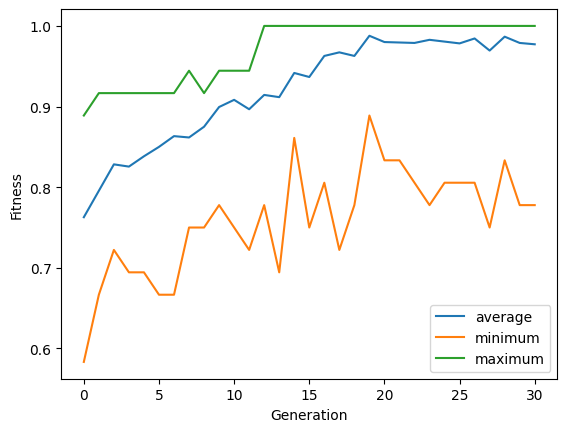

In [185]:
import matplotlib.pyplot as plt
gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()